<a href="https://colab.research.google.com/github/shashi3876/Ottawa_Data/blob/main/Ottawa_Data_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis of City of Ottawa Monthly Service Data

In this post, we wil use time series methods on the city of Ottawa servce calls dataset to predict the future values. We will compare three different forecasting methods using the mean absolute error as the key performance indicator (KPI).

As previuosly mentioned in the other notebook, this data is freely available on the data [portal](https://open.ottawa.ca/search?collection=Dataset&q=service) offered by city of Ottawa. The data portal states the following regarding these data.

*The data provides a summary of requests for service that require action by City staff.The data provides a summary of requests for service that require action by City staff. Data is presented by ward and shows the responsible City department and service request description.*

I have downloaded the available service call data in to my google drive. Lets load these data for the year 2019-2022.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


file_path = '/content/gdrive/My Drive/Colab Notebooks/Data/SR-2019.xlsx'
records2019 = pd.read_excel(file_path)#,encoding='utf16')

file_path = '/content/gdrive/My Drive/Colab Notebooks/Data/SR-2020.xlsx'
records2020 = pd.read_excel(file_path)#,encoding='utf16')

file_path = '/content/gdrive/My Drive/Colab Notebooks/Data/2021_Monthly_Service_Requests_EN.xlsx'
records2021 = pd.read_excel(file_path)#,encoding='utf16')

file_path = '/content/gdrive/My Drive/Colab Notebooks/Data/2022_Monthly_Service_Requests.csv'
records2022 =pd.read_csv(file_path)

Everything seems working correctly. Now lets concat the four dataframes in to a single dataframe along the axis 0 (rows).

In [3]:
records=pd.concat([records2019,records2020,records2021,records2022],axis=0)


# Getting data for each day

Here we'll aggeragte the service requests for each day and obtain a new dataframe for further processing. Also lets plot the whole graph and a zoomed in part of the graph.

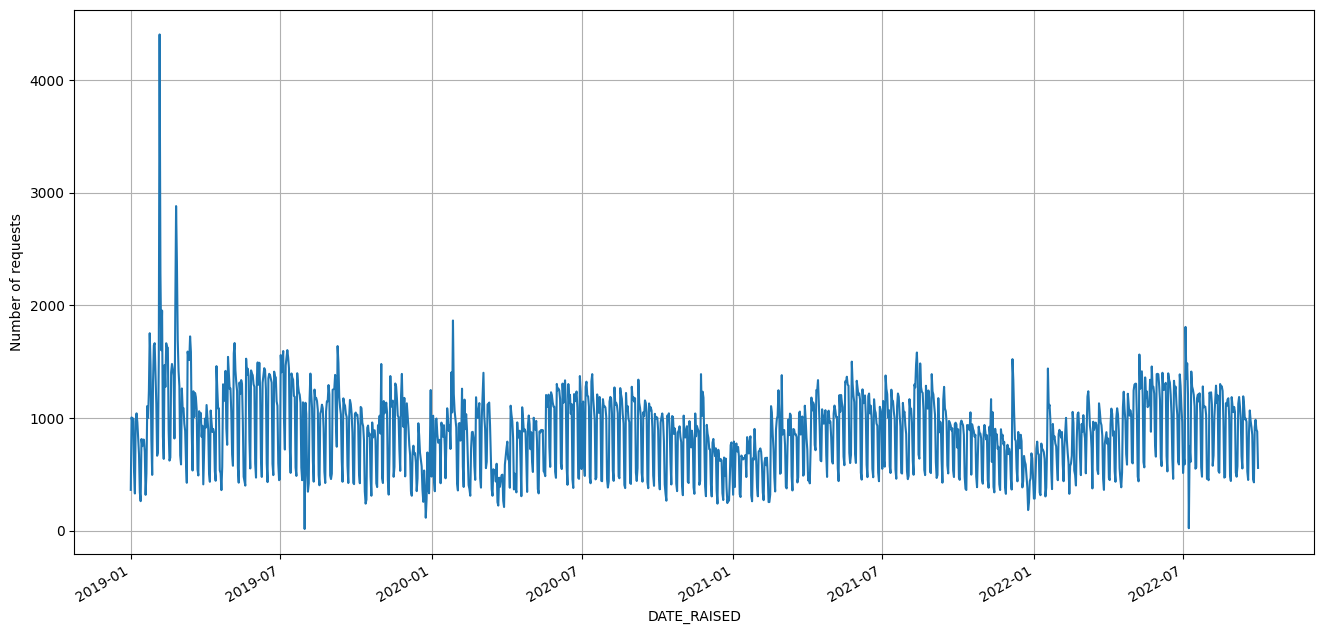

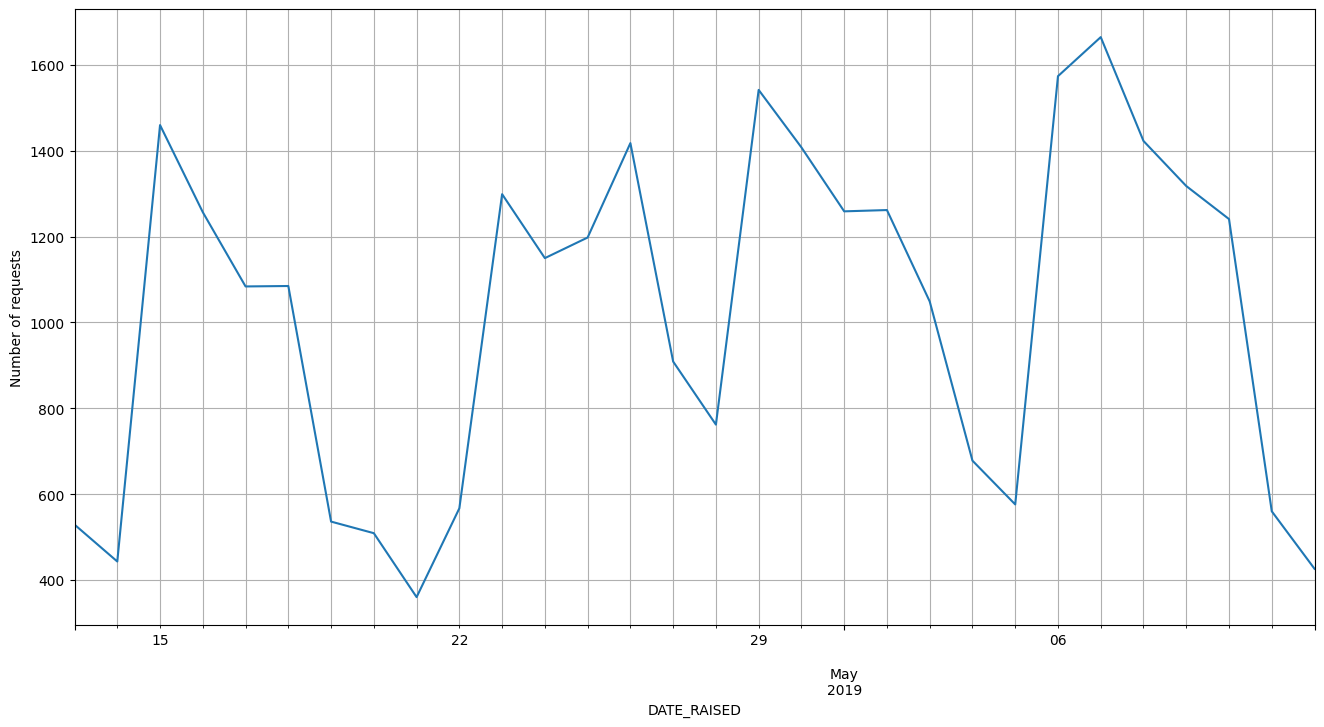

In [4]:
records["DATE_RAISED"]=pd.to_datetime(records.DATE_RAISED)
record_by_date=records.groupby("DATE_RAISED")["TYPE"].count().sort_index()
record_by_date.plot(figsize = (16, 8))
plt.ylabel('Number of requests')
plt.grid(visible=True,which='both')
plt.figure()

record_by_date.iloc[100:130].plot(figsize = (16, 8))
plt.ylabel('Number of requests')
plt.grid(visible=True,which='both')

##Check for missing dates

Now lets check if any of the dates are missing in our timeseries.

In [5]:
start_date = record_by_date.index.min()
end_date = record_by_date.index.max()

# create a complete date range for the period of interest
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# compare the date range to the index of the time series
missing_dates = date_range[~date_range.isin(record_by_date.index)]

if len(missing_dates) > 0:
    print("Missing dates:", missing_dates)
else:
    print("No missing dates")


Missing dates: DatetimeIndex(['2019-01-31', '2019-03-31', '2021-12-31'], dtype='datetime64[ns]', freq=None)


There are 3 missing dates in our timeseries. Lets add these dataes to the index and fill their values with the average of the neighbouring dates.

In [6]:
# Reindex to fill missing dates
idx = pd.date_range(start=record_by_date.index.min(), end=record_by_date.index.max(), freq='D')
record_by_date = record_by_date.reindex(idx, fill_value=0)

# Add missing dates with average of surrounding values
for date in missing_dates:
    prev_date = date - pd.DateOffset(days=1)
    next_date = date + pd.DateOffset(days=1)
    prev_val = record_by_date.loc[prev_date] if prev_date in record_by_date.index else np.nan
    next_val = record_by_date.loc[next_date] if next_date in record_by_date.index else np.nan
    avg_val = np.nanmean([prev_val, next_val])
    record_by_date.loc[date] = avg_val

## Evaluations of the models

To evaluate any time series model, we need to define some error functions. In this case, we will look at three commonly used error functions: Mean Squared Error (MSE), Mean Absolute Error (MAE), and Symmetric Mean Absolute Percentage Error (SMAPE).

Mean Squared Error (MSE) measures the average squared difference between the predicted and actual values of the time series. It is calculated as follows:

$ MSE = \frac{1}{n}\Sigma_{i=1}^{n} \left(y_{true}[i] - y_{pred}[i]\right)^2$

where $y_{true}$ is the actual value of the time series, $y_{pred}$ is the predicted value of the time series, and $n$ is the number of observations.

Mean Absolute Error (MAE) measures the average absolute difference between the predicted and actual values of the time series. It is calculated as follows:

css
Copy code
MAE = 1/n * Σ(i=1 to n) |y_true[i] - y_pred[i]|
where y_true is the actual value of the time series, y_pred is the predicted value of the time series, and n is the number of observations.

Symmetric Mean Absolute Percentage Error (SMAPE) measures the percentage difference between the predicted and actual values of the time series, and is symmetric around zero. It is calculated as follows:

css
Copy code
SMAPE = 1/n * Σ(i=1 to n) [2 * |y_pred[i] - y_true[i]| / (|y_true[i]| + |y_pred[i]|)]
where y_true is the actual value of the time series, y_pred is the predicted value of the time series, and n is the number of observations.

All three error functions provide a way to measure the accuracy of the time series model. A lower value for MSE, MAE, or SMAPE indicates a better fit between the predicted and actual values of the time series. It is important to note that MSE, MAE, and SMAPE may have different sensitivities to outliers, depending on the nature of the data.

In addition to MSE and SMAPE, MAE is another commonly used error function to evaluate time series models. MAE is less sensitive to outliers compared to MSE, making it a more robust measure of accuracy in the presence of outliers.
To evaluate any time series model, we need to define some error functions. In this case, we will look at three commonly used error functions: Mean Squared Error (MSE), Mean Absolute Error (MAE), and Symmetric Mean Absolute Percentage Error (SMAPE).

Mean Squared Error (MSE) measures the average squared difference between the predicted and actual values of the time series. It is calculated as follows:

All three error functions provide a way to measure the accuracy of the time series model. A lower value for MSE, MAE, or SMAPE indicates a better fit between the predicted and actual values of the time series. It is important to note that MSE, MAE, and SMAPE may have different sensitivities to outliers, depending on the nature of the data.
We are using all three of these functions to compare the results we obtain from various time series methods. MAE and MSE is available in scikit-learn. However, a function for SMAPE is not readily available. So lets import the necessary packages for MAE and MSE and write a small function to calculate SMAPE.

In [7]:

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)) * 100

#Train test split

Here we split our data set to a train and test set. We will use 80% of our data as the train set and the rest as the test set.

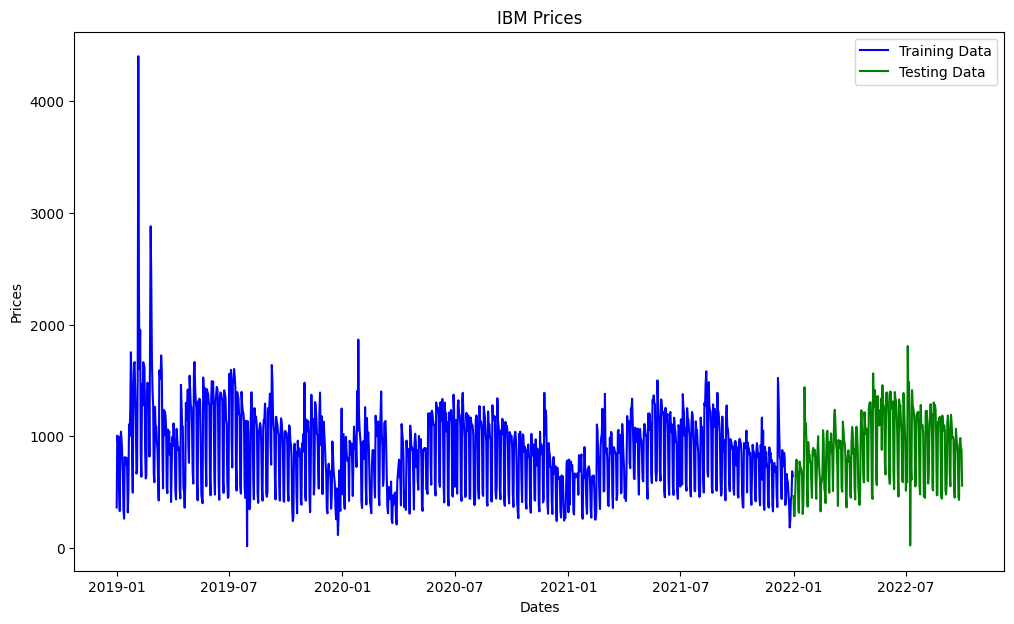

In [8]:
train_data, test_data = record_by_date.iloc[0:int(len(record_by_date)*0.8)], record_by_date.iloc[int(len(record_by_date)*0.8):]
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data, 'blue', label='Training Data')
plt.plot(test_data, 'green', label='Testing Data')
plt.legend()

#  ARIMA Model

In this section we will use an Arima model to predict the future values. First we have to find the three parameters p,d, and q for our dataset. Here p is the order of the autoregressive (AR) term, d is the degree of differencing needed to make the time series stationary, and q is the order of the moving average (MA) term. To find these parameters, we can use a combination of visual inspection of time series plots and statistical tests such as the augmented Dickey-Fuller (ADF) test. Once we have determined the values of p, d, and q, we can fit an ARIMA model to our data and use it to make predictions for future values. 

## Finding p value

To determine the value of p, we look at the partial autocorrelation function (PACF) plot. This plot shows the correlation between an observation and its lagged values, after accounting for the relationship between the observation and its intermediate lags. We identify the order of p by looking for the lag at which the PACF plot first crosses the significance level.


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


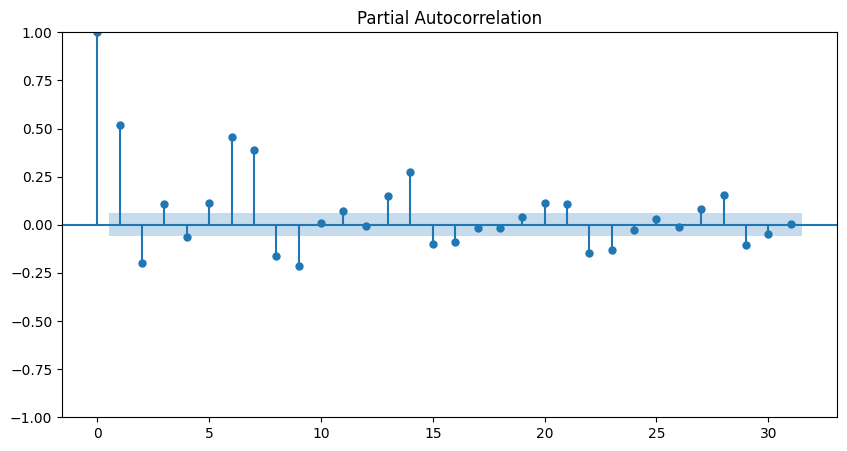

In [9]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

# Plot PACF plot to find p
fig, ax = plt.subplots(figsize=(10,5))
plot_pacf(train_data, ax=ax)
plt.show()

According to the above PACF plot, even after 30 lags, we can see some correlation above the significance level of 0.05. This indicates that there is a long-term trend or seasonality present in data. Thus, some other methods like seasonal Arima may be more suitable for this data. However for now, lets take p as 14.

## Finding optimum d value

To find the optimal value of d we can use the ADF (Augmented Dickey-Fuller) method. We can run the ADF test on the time series data with different values of d and look for the value of d that results in the lowest p-value. The ADF test checks whether a unit root is present in the time series data, which is a sign of non-stationarity, and hence helps in determining the value of d.

In [10]:
from statsmodels.tsa.stattools import adfuller

# define a function to find the optimal d value
def find_optimal_d(data):
    d = 0
    adf_pvalue = 1
    while adf_pvalue > 0.05:
        adf_result = adfuller(data.diff().dropna())
        adf_pvalue = adf_result[1]
        if adf_pvalue > 0.05:
            d += 1
            data = data.diff().dropna()
    return d

# find the optimal d value for the train_data
optimal_d = find_optimal_d(train_data)

print(f'The optimal d value for the train_data is {optimal_d}.')

The optimal d value for the train_data is 0.


## Finding the optimum q value

Similar to finding p, to find the value of q, we look at the autocorrelation function (ACF) plot. This plot shows the correlation between an observation and its lagged values. We identify the order of q by looking for the lag at which the ACF plot first crosses the significance level.

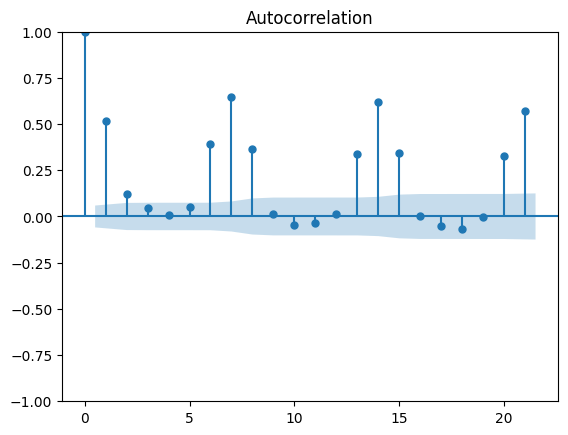

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot the ACF plot to determine the value of q
acf_plot = plot_acf(train_data, lags=21)
plt.show()

Similar to the case with p, we can still see siginifcat values for the ACF curve in this scenario. However, for this case lets take q as 8.

#ARIMA model

Having found some reasonable values for p, d, and q, let's train our ARIMA model and plot the actual and predicted values.




/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


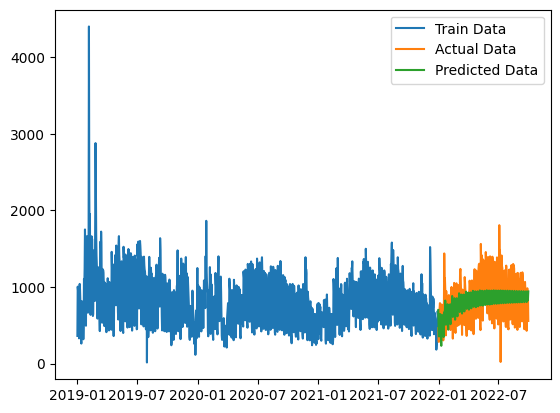

In [18]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

p=14
d=0
q=8
# Train ARIMA model on train_data
model = ARIMA(train_data, order=(p,d,q))
model_fit = model.fit()

# make predictions on test data
predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)

# plot actual and predicted values
import matplotlib.pyplot as plt
plt.plot(train_data, label='Train Data')
plt.plot(test_data, label='Actual Data')
plt.plot(predictions, label='Predicted Data')
plt.legend()
plt.show()

As seen from the above figure, our Arima model can track the actual data with some good accuracy. Lets, zoom in on the train data section for 

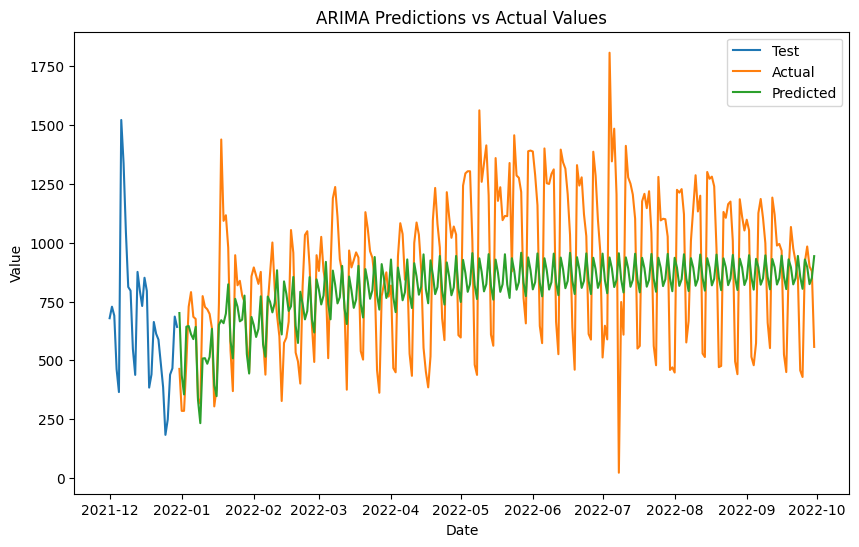

In [15]:
# plot actual and predicted values for last 30 days of test data
plt.figure(figsize=(10, 6))
plt.plot(train_data.index[-30:], train_data[-30:], label='Test')
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(test_data.index, predictions, label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA Predictions vs Actual Values')
plt.show()

In [17]:
smape_value = smape(test_data, predictions)
print("SMAPE:", smape_value)

SMAPE: 29.425036724821897


In [12]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Train ARIMA model on train_data
model = ARIMA(train_data, order=(14, 0, 8))
model_fit = model.fit()

history = [x for x in train_data]

predictions = list()
for t in range(len(test_data)):

    # START_CODE_HERE - call the ARIMA Method with history and params
    #model = ARIMA(history,order=(5,1,0))  # initialize the model with history and right order of parameters
    #model_fit = model.fit()  # fit the model
    # END_CODE_HERE

    output = model_fit.forecast()  # use forecast on the fitted model
    #print(output)
    yhat = output[0][0]
    #yhat=0;
    predictions.append(yhat)

    obs = test_data[t]
    history.append(obs)

    if t % 10 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


IndexError: ignored

In [ ]:
predictions


701.0235088065078

ValueError: ignored

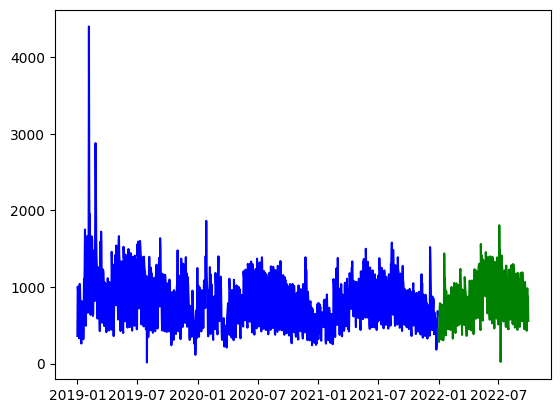

In [ ]:
# Plot the train data, actual data, and predicted values
plt.plot(train_data.index,train_data, color='blue', label='Train Data')
plt.plot(test_data.index, test_data, color='green', label='Actual Data')
plt.plot(test_data.index, predictions, color='red', label='Predicted Values')
plt.legend()
plt.show()

#Auto ARIMA models



#Deep Learning methods

#Conclusion